In [3]:
import pandas as pd
import datetime
import pytz
from scipy.stats import skew, kurtosis, t, shapiro
from statistics import variance
from datetime import *
from math import sqrt
import numpy as np
import blpapi
from binance.client import Client
from binance.spot import Spot
import requests
import os
import json
from xbbg import blp
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tabulate import tabulate
from texttable import Texttable
import latextable
import matplotlib.pyplot as plt
from sklearn.utils import resample

In [4]:
# pip install --index-url=https://bcms.bloomberg.com/pip/simple blpapi
# pip install xbbg
# %pip install blp
# I need to import the request library for APIs
# %pip install requests
# pip install vaderSentiment
# %pip install latextable
# %pip install tabulate

In [5]:
#data_SP500 = pd.read_excel('S&P 500 daily HFT data.xlsx')
data_SP500 = pd.read_csv('S&P500 full df.csv', index_col='Timestamp')
#data_SP500 = pd.read_csv('S&P500 full df.csv')
data_SP500

/Users/leo/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Date,type,price
Timestamp,,,
1633015801,2021-09-30 15:30:01,TRADE,4370.67
1633015802,2021-09-30 15:30:02,TRADE,4375.45
1633015803,2021-09-30 15:30:03,TRADE,4375.46
1633015804,2021-09-30 15:30:04,TRADE,4375.47
1633015805,2021-09-30 15:30:05,TRADE,4375.71
...,...,...,...
1647037197,2022-03-11 22:19:57,TRADE,4204.31
1647037198,2022-03-11 22:19:58,TRADE,4204.31
1647037199,2022-03-11 22:19:59,TRADE,4204.31


# Collection of the data and pre-processing


In [ ]:
# S&P 500 data collection 

# dropping the columns without values 
data_SP500 = data_SP500.drop(columns=['Unnamed: 0', 'Unnamed: 5', 'Unnamed: 10'])

# creating 3 different df for the differet columns inside the excel file and then I will concatenate them 
# to have all the high frequency data of the S&P 500 from 30 september 2021
data_SP500_1 = data_SP500.iloc[:, 0:3].dropna(axis=0)
data_SP500_2 = data_SP500.iloc[:, 4:7].dropna(axis=0)
data_SP500_3 = data_SP500.iloc[:, 8:11].dropna(axis=0)

# renaming the columns of the df to concatenate them 
data_SP500_1 = data_SP500_1.rename(columns ={'Unnamed: 1':'Date', 'Unnamed: 2':'type', 'Unnamed: 3':'price', 'Unnamed: 4':'volume'})
data_SP500_2 = data_SP500_2.rename(columns ={'Unnamed: 6':'Date', 'Unnamed: 7':'type', 'Unnamed: 8':'price', 'Unnamed: 9':'volume'})
data_SP500_3 = data_SP500_3.rename(columns ={'Unnamed: 11':'Date', 'Unnamed: 12':'type', 'Unnamed: 13':'price', 'Unnamed: 14':'volume'})


# concatenating the three df so that I have just one df with all the prices in sequence by time
data_SP500 = pd.concat([data_SP500_1, data_SP500_2, data_SP500_3])


# np.where(type(data_SP500_1.Date) is str, pd.to_datetime(data_SP500_1.Date), datetime.strptime(datetime.strftime(data_SP500_1.Date, '%Y,%d,%m,%I:%M:%S'), '%Y,%m,%d,%I:%M:%S'))
# datetime.strptime(datetime.strftime(data_SP500_1.Date.mask(type(data_SP500_1.Date) is str), '%Y,%d,%m,%I:%M:%S'), '%Y,%m,%d,%I:%M:%S')
#data_SP500_1.Date[(type(data_SP500_1.Date) is str)]
# data_SP500_1.Date[(type() is str)== True]

# datetime.strptime(datetime.strftime(data_SP500_1.Date[data_SP500_1.Date.apply(lambda x: isinstance(x, datetime))], '%Y,%d,%m,%I:%M:%S'), '%Y,%m,%d,%I:%M:%S')
#(data_SP500_1.Date.apply(lambda x: isinstance(x, datetime))).strftime([data_SP500_1.Date.apply(lambda x: isinstance(x, datetime))],  '%Y,%d,%m,%I:%M:%S')
#(pd.to_datetime(data_SP500_1.Date[data_SP500_1.Date.apply(lambda x: isinstance(x, datetime))])).dt.strftime(data_SP500_1.Date[data_SP500_1.Date.apply(lambda x: isinstance(x, datetime))], '%Y,%d,%m,%I:%M:%S')


# selecting only the stirings and making them Datetime objects (to do after fixing the format issue of datetime ones)
# data_SP500_1.Date[data_SP500_1.Date.apply(lambda x: isinstance(x, str))] = pd.to_datetime(data_SP500_1.Date[data_SP500_1.Date.apply(lambda x: isinstance(x, str))])

# making all the dates in datetime format with year, month, day...
data_SP500.Date[data_SP500.Date.apply(lambda x: isinstance(x, datetime))] = data_SP500.Date[data_SP500.Date.apply(lambda x: isinstance(x, datetime))].apply(lambda x: datetime.strftime(x, '%Y-%d-%m %I:%M:%S %p'))
data_SP500.Date = pd.to_datetime(data_SP500.Date)

# computing also the date in the timestamp - epoch format
data_SP500.Timestamp = ((data_SP500.Date - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))
data_SP500.Timestamp = data_SP500.Timestamp.apply(lambda x: '%.0f' % x)
# setting the timestamp as index for the df
data_SP500 = data_SP500.set_index(data_SP500.Timestamp)
data_SP500 = data_SP500.drop(columns=['Timestamp'])
data_SP500

# converting the 12h time formats to 24h without "PM"
datetime.strptime(data_SP500['Unnamed: 1'][0][:], '%Y,%m,%d,%I:%M:%S %p')

data_SP500 = data_SP500.reset_index()
data_SP500.Date.datetime.values.astype(np.int64) // 10 ** 9
data_SP500.Date.to_timestamp(how='s')

data_SP500.Timestamp = ((data_SP500.Date - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))
data_SP500.Timestamp = data_SP500.Timestamp.apply(lambda x: '%.0f' % x)
data_SP500 = data_SP500.set_index(data_SP500.Timestamp)
data_SP500 = data_SP500.drop(columns=['Timestamp'])
data_SP500


In [6]:
#computing the log returns for all the prices available 
data_SP500['ret'] = np.log(data_SP500.price/data_SP500.price.shift())

'OR BETTER TO USE LOG RETURNS? np.log(.price../.price shifted..)        there seem to be no differences at all'

In [9]:
# looking at the trading activity details (descriptive statistics) of the 24-02 (day in which the war started)
# data_SP500[data_SP500['Date'].str.contains('2022-02-24 15:45:0')].describe()

# crating a df for the war analysis on the S&P 500
war = data_SP500.loc[1645654792:1645717590] # last 10 trades of the previous day for the closing price and 16 mins 
# of the current day in order to have 1000 rows of data



In [10]:
# at 20 there was the FOMC press conference - Powell spoke 
(data_SP500[data_SP500['Date'].str.contains('2021-12-15 20:00')])

tapering = data_SP500.loc[1639598000:1639599000] # 5 minutes before and 10 mins after in order to have 1000 rows of data


In [11]:
# live announcement (From Powell) that possible rate hike will come in March (1+ month from the news)
(data_SP500[data_SP500['Date'].str.contains('2022-01-26 20:09')])

rates_hike = data_SP500.loc[1643226800:1643227800] # 7 minutes before and 10 mins after in order to have 1000 rows of data


# <span style="color:red">Abnormal Returns and T-Test</span> 

## computing AR, AAR and CAAR. the p-values for the AAR every 10 seconds after the event are computed according to the methodology used by Brown and Warner (1980) (from thesis 1 vu page 23)



<span style="color:green">I also check for normality in the distribution of AR. When the p value of AAR is lower that 0.05, then I can reject the null hypothesis that the news have no impact on the returns</span> 
 

In [22]:
# using 5 mins (300) as event window and 120 mins=2 hours(7200)


# defining a function to compute the abnormal returns over 10 seconds interval
def abn_returns_10s_new(df):
    # I will always compute the abnormal returns for the 5 minutes after the news and use as estimation window the 
    # 10 mins before. So the df will have exactly 300+7200=7500 rows and the position 7200 will be the news
    avg_ret = df.ret.iloc[0:7200].mean()
    ar = pd.DataFrame(columns=['Date', 'AAR', 'CAR', 'CAAR'], index = range(0,30))  # index = df.Date.iloc[600:]
    n = 7200
    ar['significance'] = ''
    ar['significance_CAR'] = ''
    ar['significance_AR'] = ''
    df['AR'] = df.ret - avg_ret
    
    # trying to compute the CAR in a meaningful way 
    df['CAR'] = 0
    df.CAR.iloc[7200:7500] = df.AR.iloc[7200:7500].cumsum()
    
    df = df.fillna(0)
    AAR = df.AR.iloc[0:7200].mean()
    # considering the return every 10 seconds (or better to use the average return over the 10 seconds?)
    for i in range(0, 30):
        ar.Date.iloc[i] = df.Date.iloc[n]
    # AR is: observed ret-average
    # I compute the Cumulative Abnormal Return for every 10 seconds
        ar.CAR.iloc[i] = df.CAR.iloc[n:n+10].mean()
 
    # I compute the Average Abnormal Return for every 10 seconds
        ar.AAR.iloc[i] = df.AR.iloc[n:n+10].mean()
        
        n = n +10
    # I compute the Cumulative Average Abnormal Return for every 10 seconds, summing the AAR    
    ar.CAAR = ar.AAR.cumsum()
    
   
    
    # formula to compute the p-value
    # using the shapiro test for normality:
    shapiro_test_norm = shapiro(ar.CAR).pvalue
    ##################### I am not using this Jarque-Bera test anymore because is not the best and not so reliable
    # using the Jarque-Bera test for normality:
#     test_for_norm = (300/6)*((skew(df.AR.iloc[7200:7500].cumsum())**2)*(((kurtosis(df.AR.iloc[7200:7500].cumsum())-3)**2)/4))
#     test_for_norm = (len(ar.CAR)/6)*((skew(ar.CAR)**2)*(((kurtosis(ar.CAR)-3)**2)/4))
#     print('J-B Test for normality: ' + str(test_for_norm), 'Shapiro Test for normality: ' + str(shapiro_test_norm))

    print('Shapiro Test for normality: ' + str(shapiro_test_norm))
    
    if shapiro_test_norm > 0.05:  #  test_for_norm < 0.05 or 
        
        
        ar['t_test_CAR'] = ar.CAR/np.std(ar.CAR)
        ar['t_test_AR'] = ar.AAR/np.std(ar.AAR)
        
        ar.significance_CAR.loc[ar['t_test_CAR'] >= 1.65] = '*'
        ar.significance_CAR.loc[ar['t_test_CAR'] <= -1.65] = '*'
        ar.significance_CAR.loc[ar['t_test_CAR'] >= 1.96] = '**'
        ar.significance_CAR.loc[ar['t_test_CAR'] <= -1.96] = '**'
        ar.significance_CAR.loc[ar['t_test_CAR'] >= 2.58] = '***'
        ar.significance_CAR.loc[ar['t_test_CAR'] <= -2.58] = '***'
        
        ar.significance_AR.loc[ar['t_test_AR'] >= 1.65] = '*'
        ar.significance_AR.loc[ar['t_test_AR'] <= -1.65] = '*'
        ar.significance_AR.loc[ar['t_test_AR'] >= 1.96] = '**'
        ar.significance_AR.loc[ar['t_test_AR'] <= -1.96] = '**'
        ar.significance_AR.loc[ar['t_test_AR'] >= 2.58] = '***'
        ar.significance_AR.loc[ar['t_test_AR'] <= -2.58] = '***'
        print('Normal distributed CAR')
        
        
    # sigma of AR in the estimation window
    sigma = sqrt(sum((df.AR.iloc[0:7200]-AAR)**2)/7200)

    # computing t-statistics for AAR and CAAR
    ar['t_test_AAR'] = ar.AAR/sigma
    ar['t_test_CAAR'] = ar.CAAR/((301**0.5)*sigma)

    ar['significance_CAAR'] = ''
    ar.significance_CAAR.loc[ar['t_test_CAAR'] >= 1.65] = '*'
    ar.significance_CAAR.loc[ar['t_test_CAAR'] <= -1.65] = '*'
    ar.significance_CAAR.loc[ar['t_test_CAAR'] >= 1.96] = '**'
    ar.significance_CAAR.loc[ar['t_test_CAAR'] <= -1.96] = '**'
    ar.significance_CAAR.loc[ar['t_test_CAAR'] >= 2.58] = '***'
    ar.significance_CAAR.loc[ar['t_test_CAAR'] <= -2.58] = '***'
    
    
    ar.significance.loc[ar['t_test_AAR'] >= 1.65] = '*'
    ar.significance.loc[ar['t_test_AAR'] <= -1.65] = '*'
    ar.significance.loc[ar['t_test_AAR'] >= 1.96] = '**'
    ar.significance.loc[ar['t_test_AAR'] <= -1.96] = '**'
    ar.significance.loc[ar['t_test_AAR'] >= 2.58] = '***'
    ar.significance.loc[ar['t_test_AAR'] <= -2.58] = '***'
    # setting the degrees of freedom: in the reference paper are 120 (days of the estimation window - 1)
    # so here are 7200 - 1 = 7199
    dof = 7199
    for i in range(0, len(ar.t_test_AAR)):
        ar.t_test_AAR.iloc[i] = 2*(1 - t.cdf(abs(ar.t_test_AAR.iloc[i]), dof))
    
    ar = ar.set_index('Date')
    
    
    
    
    # creating a df in which i compute the AR over the first minute to do the analysis with high frequency data
    df_abn_ret = pd.DataFrame()
    df_abn_ret['AR'] = df.AR.iloc[7260:]
    df_abn_ret['t_test_AR'] = (df.AR.iloc[7260:]/np.std(df.AR.iloc[0:7260]))
    df_abn_ret['CAR'] = df_abn_ret.AR.cumsum()
    # computing the significance level:
    df_abn_ret['signif'] = 0.0
    df_abn_ret.signif.loc[df_abn_ret['t_test_AR'] >= 1.65] = '*'
    df_abn_ret.signif.loc[df_abn_ret['t_test_AR'] <= -1.65] = '*'
    df_abn_ret.signif.loc[df_abn_ret['t_test_AR'] >= 1.96] = '**'
    df_abn_ret.signif.loc[df_abn_ret['t_test_AR'] <= -1.96] = '**'
    df_abn_ret.signif.loc[df_abn_ret['t_test_AR'] >= 2.58] = '***'
    df_abn_ret.signif.loc[df_abn_ret['t_test_AR'] <= -2.58] = '***'
    avg_car_1 = df_abn_ret.CAR.iloc[0:60].mean()
    avg_car_10 = df_abn_ret.CAR.iloc[0:600].mean()

    print(df_abn_ret.iloc[0:60], avg_car_1, avg_car_10)
    
    return df_abn_ret
    

In [44]:
# running the funciton to obtain the AR, CAR, CAAR, AAR and the significance of the values
# taking 7200 sec before and 700 after, because I need 600 fro the CAR mean, but the event window is 300


# 26 jan - interest rates hike (with 1 data each 10 seconds (30 rows result))
abnormal_ret_rates_hike = abn_returns_10s_new(data_SP500.loc[1643219940:1643227840]) 

# 15 dec - tapering (with 1 data each 10 seconds (30 rows result))
abnormal_ret_tappering = abn_returns_10s_new(data_SP500.loc[1639591140:1639599040]) 
# with all the seconds (300 rows result)

# 24 feb - war 
# I first need to trdop the wrong trades after 22 (because the market is closed and returns are all close to 0)
clean_23_feb = data_SP500.loc[1645646340:1645717240]
clean_23_feb.drop(index= range(1645653601,1645654801), inplace=True)
clean_23_feb.drop(index= [1645657418], inplace=True) 
# (with 1 data each 10 seconds (30 rows result))
abnormal_ret_war = abn_returns_10s_new(clean_23_feb)
# with all the seconds (300 rows result)



# and also for CRIX:
abnormal_ret_tappering_1 = abn_returns_10s_new(tapering_1.loc[1639583940:1639594440])
abnormal_ret_rates_hike_1 = abn_returns_10s_new(rates_hike_1.loc[1643216340:1643223840]) 
abnormal_ret_war_1 = abn_returns_10s_new(war_1.loc[1645661940:1645669440])



<ipython-input-22-cf550e6ce033>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AR'] = df.ret - avg_ret
<ipython-input-22-cf550e6ce033>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CAR'] = 0
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Shapiro Test for normality: 0.4611281156539917
Normal distributed CAR
                  AR  t_test_AR       CAR signif
Timestamp                                       
1639591200 -0.000003  -0.021775 -0.000003    0.0
1639591201  0.000000   0.000000 -0.000003    0.0
1639591202 -0.000086  -0.609215 -0.000089    0.0
1639591203 -0.000072  -0.511283 -0.000162    0.0
1639591204 -0.000209  -1.475781 -0.000370    0.0
1639591205  0.000281   1.986218 -0.000089     **
1639591206 -0.000083  -0.590324 -0.000173    0.0
1639591207 -0.000025  -0.173283 -0.000197    0.0
1639591208  0.000025   0.174584 -0.000173    0.0
1639591209 -0.000020  -0.144855 -0.000193    0.0
1639591210  0.000016   0.114080 -0.000177    0.0
1639591211  0.000105   0.742637 -0.000072    0.0
1639591212  0.000022   0.156583 -0.000050    0.0
1639591213  0.000174   1.231966  0.000124    0.0
1639591214  0.000061   0.431051  0.000185    0.0
1639591215  0.000179   1.267442  0.000365    0.0
1639591216 -0.000137  -0.968469  0.000228    0.0

/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

                      AR  t_test_AR           CAR signif
Timestamp                                               
1643223600  9.150231e-07   0.005831  9.150231e-07    0.0
1643223601  0.000000e+00   0.000000  9.150231e-07    0.0
1643223602 -2.803823e-04  -1.786589 -2.794673e-04      *
1643223603 -2.478468e-04  -1.579274 -5.273141e-04    0.0
1643223604 -4.337231e-04  -2.763673 -9.610372e-04    ***
1643223605  2.017074e-04   1.285274 -7.593298e-04    0.0
1643223606  8.129899e-04   5.180351  5.366011e-05    ***
1643223607  8.092993e-04   5.156835  8.629594e-04    ***
1643223608  1.365315e-03   8.699753  2.228275e-03    ***
1643223609  1.447915e-03   9.226077  3.676189e-03    ***
1643223610  1.536811e-03   9.792518  5.213000e-03    ***
1643223611  1.246423e-03   7.942174  6.459423e-03    ***
1643223612  1.245114e-03   7.933834  7.704536e-03    ***
1643223613  8.023768e-04   5.112725  8.506913e-03    ***
1643223614  2.349489e-03  14.970885  1.085640e-02    ***
1643223615 -2.109449e-04  -1.34

/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

# <span style="color:red">Cumulative returns in 15 mins interval</span> 

In [15]:
# making small df for each news in order to plot them easily
# for interest rtes
plot_rate = data_SP500.loc[1643226600:1643228400]
plot_rate['time_event'] = (plot_rate.index-1643227200)/60
plot_rate = plot_rate.set_index('time_event')

# for tapering
plot_tap = data_SP500.loc[1639597800:1639599600]
plot_tap['time_event'] = (plot_tap.index-1639598400)/60
plot_tap = plot_tap.set_index('time_event')

# for war
clean_23_feb = data_SP500.loc[1645653001:1645717801] 
clean_23_feb.drop(index= range(1645653601,1645654801), inplace=True)
clean_23_feb.drop(index= [1645657418], inplace=True) 
clean_23_feb = clean_23_feb.reset_index()
clean_23_feb = clean_23_feb.set_index('Date')
plot_war = clean_23_feb
ed = plot_war.loc['2022-02-24 15:30:01'].Timestamp
plot_war['time_event'] = (plot_war.Timestamp-ed)/60
plot_war.loc['2022-02-23 21:50:00':'2022-02-23 22:00:00'].time_event = plot_war.loc['2022-02-23 21:50:00':'2022-02-23 22:00:00'].time_event + 1050
plot_war = plot_war.set_index('time_event')


<ipython-input-15-8eda155e0068>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_rate['time_event'] = (plot_rate.index-1643227200)/60
<ipython-input-15-8eda155e0068>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_tap['time_event'] = (plot_tap.index-1639598400)/60
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

Seems to be verified what stated in one paper: "***Compared to previous research, we find that prices respond more quickly: a positive return in the first two minutes, with a partial reversal in the third minute.***"

# Import binance data that I need (can have them only for 1 hour) 


# <span style="color:red">Crypto analysis</span> 

### the cryptos I will consider are the one in the CRIX on the date of 10-05-2022 and they are:
### BTC, ETH, BNB, LUNA, SOL, XRP, ADA, DOT, AVAX

In [ ]:
# function to create DF and modify the column names
def pre_processing_CC(c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9, start_time, end_time):
    global new_df0
# creating the index for Cryptos:
# the CC will be: BTC, .........
    cc = [c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9]
    
    
    for i in range(0, 9):
        cc_use = cc[i]
        response = requests.get('https://api.binance.com/api/v3/aggTrades?symbol=%(cc_use)s&startTime=%(start_time)s&endTime=%(end_time)s' %locals())
        df = response.json()

    # list with weights
        weights = [0.5562, 0.2635, 0.0481, 0.0263, 0.0266, 0.0253, 0.0242, 0.0154, 0.0144] 
        
        data = pd.DataFrame(df)
        data = data.drop(columns=['a', 'm', 'M', 'f', 'l', 'q'])
        data = data.rename(columns={'T': 'Timestamp', 'p':'price'}) #, 'q':'quantity'
        data.Timestamp = data.Timestamp.astype(str)
        data.Timestamp = data.Timestamp.str.slice(stop=-3)
        data.Timestamp = data.Timestamp.astype(int)
        data.price = data.price.astype(float)
        data = data.groupby(by=['Timestamp']).mean()
        data['Date'] =  pd.to_datetime(data.index, unit='s')
        
#         data = data.set_index('Timestamp')
       
        
        
        if i == 0:
            globals()['new_df'+str(i)] = pd.DataFrame(df)
         # dropping the columns that are not needed in this phase:
            globals()['new_df'+str(i)] = globals()['new_df'+str(i)].drop(columns=['a', 'm', 'M', 'f', 'l', 'q'])
            globals()['new_df'+str(i)] = globals()['new_df'+str(i)].rename(columns={'T': 'Timestamp', 'p':'price'}) # , 'q':'quantity'
            # to consider just the timestamp till the seconds ===> is better for the index creation because instead is difficut
            # to get the same timestamp and create prices. In this way I can simply create prices every second
            globals()['new_df'+str(i)].Timestamp = globals()['new_df'+str(i)].Timestamp.astype(str)
            globals()['new_df'+str(i)].Timestamp =  globals()['new_df'+str(i)].Timestamp.str.slice(stop=-3)
            # adding a column with the date
            globals()['new_df'+str(i)]['Date'] =  pd.to_datetime(globals()['new_df'+str(i)].Timestamp, unit='s')
            
            #.tz_convert('Europe/Berlin')

            # making the price, Timestamp and the quantity floats
            globals()['new_df'+str(i)].price = globals()['new_df'+str(i)].price.astype(float)


#             globals()['new_df'+str(i)].quantity = globals()['new_df'+str(i)].quantity.astype(float)
            globals()['new_df'+str(i)].Timestamp = globals()['new_df'+str(i)].Timestamp.astype(int)

            # grouping by timestamp and taking the average (just price needed in this analysis)
            globals()['new_df'+str(i)] = globals()['new_df'+str(i)].groupby(by=['Date']).mean()
            globals()['new_df'+str(i)].index = globals()['new_df'+str(i)].index #.tz_localize('Europe/Berlin')


            # creating a column with returns 



            # setting timestamp as index
            globals()['new_df'+str(i)] = globals()['new_df'+str(i)].reset_index()
            globals()['new_df'+str(i)] = globals()['new_df'+str(i)].set_index('Timestamp')

            
        
        
        
        else:
            
            # globals()['new_df'+str(i)].price.loc[globals()['new_df'+str(i)].Timestamp.loc[data.T].index] = data.p
            # get the list of timestamps of both the dfs: 
            ind_0 = list(new_df0.index)
            ind_1 = list(data.index)
            
            # make the difference betweeen the lists and create a new one with just the common ones
            diff = list(set(ind_1) - set(ind_0))    # new dates to add to the starting df
            common = list(set(ind_1) - set(diff))    # common dates to both the df
            missing = list(set(ind_0) - set(ind_1))     # dates that are missing in the new df but are in the reference one
    
            # add the missing rows to the STARTING dataframe 
            to_add = pd.DataFrame(data.loc[diff])
            to_add.price = 0
#             to_add = pd.DataFrame(0, index=diff, columns=['Date', 'price', 'quantity'])
            
            # adding the missing rows to the starting DF in order to have them all complete with all the trades
            new_df0 = new_df0.append(to_add)

            
            # fixing the referece df: new_df0:
            # sort the df by timestamp
            new_df0 = new_df0.reset_index()
            new_df0 = new_df0.sort_values(by='Timestamp')
            
            # setting again Timestamp as index
            new_df0 = new_df0.set_index('Timestamp')
                
                
            # creating the new df
            globals()['new_df'+str(i)] = new_df0

            
#             # sort the df by timestamp
#             globals()['new_df'+str(i)] = globals()['new_df'+str(i)].reset_index()
#             globals()['new_df'+str(i)] = globals()['new_df'+str(i)].sort_values(by='Timestamp')
#             # setting again Timestamp as index
#             globals()['new_df'+str(i)] = globals()['new_df'+str(i)].set_index('Timestamp')


            # add the prices to the df of interest with the whole list of dates        
            globals()['new_df'+str(i)].loc[common] = data.loc[common]  # data.index.isin(common)
            
            # I also have to change the values of the missing one to NaN in order to then use the previous price
            globals()['new_df'+str(i)].price.loc[missing] = 0  
            
            
            # change NaN with price in the previous day
            for k in range(0, len(globals()['new_df'+str(i)])):
                if globals()['new_df'+str(i)].price.iloc[k] == 0:
                    globals()['new_df'+str(i)].price.iloc[k] = globals()['new_df'+str(i)].price.iloc[k-1]
                    p = k
                    while globals()['new_df'+str(i)].price.iloc[k] == 0:
                        globals()['new_df'+str(i)].price.iloc[k] = globals()['new_df'+str(i)].price.iloc[p]
                        p = p +1


        
   
    # making the final anc complete df with the prices of the index based on the weights   
    final_df = new_df0
    final_df.price = new_df0.price*weights[0]+new_df1.price*weights[1]+new_df2.price*weights[2]+new_df3.price*weights[3]+new_df4.price*weights[4]+new_df5.price*weights[5]+new_df6.price*weights[6]+new_df7.price*weights[7]+new_df8.price*weights[8]
    
    # computing the returns 
    final_df['ret'] = ((final_df.price - final_df.price.shift())/final_df.price.shift()).astype(float)
    
    
    
    return final_df

# group by Timestamp in seconds, in order to make it easier to compare with S&P500 als because I don't need all
# these details in this phase, but I will in the specific analysis (look at quantities and market making and so on)


In [ ]:

# # taking the df with the biggest interval possible, then I will select the small intervall I need:
# # (due to the fact that I want to consider a period of time as estimation window of 2 hours, I have to create 3 df
# # because each df can have max 1 hour of data (the API))    ===> then I will merge the dfs for the same news          
# event at 18 GMT 1643220000000
rates_hike_1 = pre_processing_CC('BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LUNAUSDT', 'SOLUSDT', 'XRPUSDT', 'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 1643211000000, 1643212800000)
rates_hike_2 = pre_processing_CC('BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LUNAUSDT', 'SOLUSDT', 'XRPUSDT', 'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 1643212801000, 1643216400000)
rates_hike_3 = pre_processing_CC('BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LUNAUSDT', 'SOLUSDT', 'XRPUSDT', 'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 1643216401000, 1643220000000)
rates_hike_4 = pre_processing_CC('BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LUNAUSDT', 'SOLUSDT', 'XRPUSDT', 'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 1643220001000, 1643223600000)
rates_hike_5 = pre_processing_CC('BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LUNAUSDT', 'SOLUSDT', 'XRPUSDT', 'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 1643223601000, 1643227200000)

# tapering_AR = pre_processing_CC('BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LUNAUSDT', 'SOLUSDT', 1639591200000, 1639599000000)       
# event at 18 GMT 1639591200000
tapering_1 = pre_processing_CC('BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LUNAUSDT', 'SOLUSDT', 'XRPUSDT', 'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 1639583000000, 1639584000000)
tapering_2 = pre_processing_CC('BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LUNAUSDT', 'SOLUSDT', 'XRPUSDT', 'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 1639584001000, 1639587600000)
tapering_3 = pre_processing_CC('BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LUNAUSDT', 'SOLUSDT', 'XRPUSDT', 'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 1639587601000, 1639591200000)
tapering_4 = pre_processing_CC('BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LUNAUSDT', 'SOLUSDT', 'XRPUSDT', 'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 1639591201000, 1639594800000)
tapering_5 = pre_processing_CC('BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LUNAUSDT', 'SOLUSDT', 'XRPUSDT', 'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 1639594801000, 1639598400000)

# same for war:    1645660801000 = midnight and  sec 24-02 GMT. to 1645671600000 = 03 am 24-02 GMT 
# event at?? 2:20 GMT? 1645669200000
war_1 = pre_processing_CC('BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LUNAUSDT', 'SOLUSDT', 'XRPUSDT', 'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 1645660000000, 1645660800000)
war_2 = pre_processing_CC('BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LUNAUSDT', 'SOLUSDT', 'XRPUSDT', 'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 1645660801000, 1645664400000)
war_3 = pre_processing_CC('BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LUNAUSDT', 'SOLUSDT', 'XRPUSDT', 'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 1645664401000, 1645668000000)
war_4 = pre_processing_CC('BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LUNAUSDT', 'SOLUSDT', 'XRPUSDT', 'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 1645668001000, 1645671600000)
war_5 = pre_processing_CC('BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'LUNAUSDT', 'SOLUSDT', 'XRPUSDT', 'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 1645671600000, 1645675200000)


# creating just 1 df for each news from which I can then select the subsamples and apply the functions
rates_hike_1 = rates_hike_1.append(rates_hike_2)
rates_hike_1 = rates_hike_1.append(rates_hike_3)
rates_hike_1 = rates_hike_1.append(rates_hike_4)
rates_hike_1 = rates_hike_1.append(rates_hike_5)
rates_hike_1.ret.iloc[0] = 0.0
rates_hike_1

tapering_1 = tapering_1.append(tapering_2)
tapering_1 = tapering_1.append(tapering_3)
tapering_1 = tapering_1.append(tapering_4)
tapering_1 = tapering_1.append(tapering_5)
tapering_1.ret.iloc[0] = 0.0
tapering_1

war_1 = war_1.append(war_2)
war_1 = war_1.append(war_3)
war_1 = war_1.append(war_4)
war_1 = war_1.append(war_5)
war_1.ret.iloc[0] = 0.0
war_1

In [ ]:
# importing the already preprocessed data so that it will be easier and faster

In [43]:
rates_hike_1 = pd.read_csv('rates_hike_CRIX.csv', index_col='Timestamp')
tapering_1= pd.read_csv('tapering_CRIX.csv', index_col='Timestamp')
war_1 = pd.read_csv('war_CRIX.csv', index_col='Timestamp')

# <span style="color:red">Abnormal Returns and T-Test for CRIX and general news (same news as before)</span> 

## computing AR, AAR and CAAR. the p-values for the AAR every 10 seconds after the event are computed according to the methodology used by Brown and Warner (1980) (from thesis 1 vu page 23)

In [27]:
# running the functions to compute the AR, AAR, CAR, CAAR and test the significance 
abnormal_ret_tappering_1 = abn_returns_10s_new(tapering_1.loc[1639583940:1639594440])
abnormal_ret_rates_hike_1 = abn_returns_10s_new(rates_hike_1.loc[1643216340:1643223840]) 
abnormal_ret_war_1 = abn_returns_10s_new(war_1.loc[1645661940:1645669440])
# abnormal_ret_war_1 = abn_returns_10s_new(war_1.loc[1645665540:1645673040])


print(abnormal_ret_rates_hike_1, abnormal_ret_tappering_1, abnormal_ret_war_1)


<ipython-input-12-8c7317d138df>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AR'] = df.ret - avg_ret
<ipython-input-12-8c7317d138df>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CAR'] = 0
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Shapiro Test for normality: 0.4611281156539917
Normal distributed CAR
Shapiro Test for normality: 0.011362539604306221
Shapiro Test for normality: 0.06190422549843788
Normal distributed CAR
                          AAR       CAR      CAAR significance  \
Date                                                             
2022-01-26 18:59:00 -0.000071 -0.000415 -0.000071                
2022-01-26 18:59:10 -0.000028  -0.00116   -0.0001                
2022-01-26 18:59:20  0.000088 -0.000604 -0.000012                
2022-01-26 18:59:30  0.000164   0.00068  0.000152                
2022-01-26 18:59:40 -0.000092  0.001001   0.00006                
2022-01-26 18:59:50 -0.000066  0.000218 -0.000006                
2022-01-26 19:00:00  0.000368  0.000373  0.000361           **   
2022-01-26 19:00:10  0.001021  0.009923  0.001383          ***   
2022-01-26 19:00:20 -0.000412  0.013104   0.00097          ***   
2022-01-26 19:00:30  0.000315  0.010214  0.001286           **   
2022-01-26 19:00:4

**It seems like there are no AAR in the CRIX, this might be due to the fact that also in the previous hour the volatility and returns are higher (in abs value) and so to be considered abnormal they have to be way higher (?????)** 
### <span style="color:green">In the formula to compute AAR and the t-test I use the historical sigma (vol) as explained in the paper, this may be the cause of the non significant returns</span>

## Plot of cumulative returns in the small period of time as with S&P500

In [29]:
# making small df for each news in order to plot them easily
# for interest rtes
plot_rate_cc = rates_hike_1.loc[1643223000:1643224800]
plot_rate_cc['time_event'] = (plot_rate_cc.index-1643223600)/60
plot_rate_cc = plot_rate_cc.set_index('time_event')

# for tapering
plot_tap_cc = tapering_1.loc[1639594200:1639596000]
plot_tap_cc['time_event'] = (plot_tap_cc.index-1639594800)/60
plot_tap_cc = plot_tap_cc.set_index('time_event')

# for war
plot_war_cc = war_1.loc[1645668600:1645670400]
plot_war_cc['time_event'] = (plot_war_cc.index-1645669200)/60
plot_war_cc = plot_war_cc.set_index('time_event')


<ipython-input-29-23f42b423e2f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_rate_cc['time_event'] = (plot_rate_cc.index-1643223600)/60
<ipython-input-29-23f42b423e2f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_tap_cc['time_event'] = (plot_tap_cc.index-1639594800)/60
<ipython-input-29-23f42b423e2f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

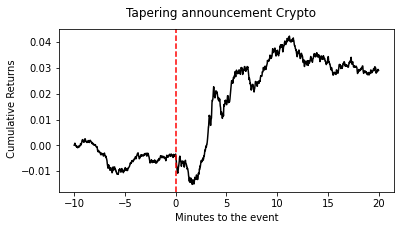

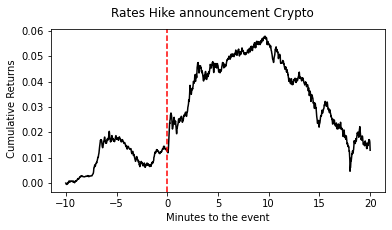

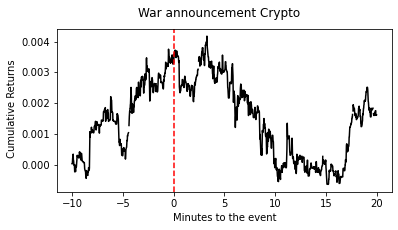

In [30]:
# tapering news impact:
fig = plt.figure(figsize = (6,3))
fig.suptitle('Tapering announcement Crypto') 
plt.plot(plot_tap_cc.ret.cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
plt.axvline(x=0, linestyle='--', color= 'red')
plt.xlabel('Minutes to the event')
plt.ylabel(' Cumulative Returns')
plt.savefig("plot_tapering_Crypto.jpg")

# rates hike
fig = plt.figure(figsize = (6,3))
fig.suptitle('Rates Hike announcement Crypto')
plt.plot(plot_rate_cc.ret.cumsum(), color= 'black')     
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
plt.axvline(x=0, linestyle='--', color= 'red')
plt.xlabel('Minutes to the event')
plt.ylabel(' Cumulative Returns')
plt.savefig("plot_rates_hike_Crypto.jpg")

# War news impact:
# starting at 1645578000000 (1 GMT and 3 Amsterdam time)
# news from forbes arrived at 4.21 amsterdam time, so 2.21 GMT     1645582800000
# finishing at 1645588800000 (1 GMT and 6 Amsterdam time)
fig = plt.figure(figsize = (6,3))
fig.suptitle('War announcement Crypto') 
plt.plot(plot_war_cc.ret.cumsum(), color= 'black')      # 1645671600
plt.axvline(x=0, linestyle='--', color= 'red')   # 1645670900 at 2.48 (18/20 mins after the news) 
# there is a movement in prices. 
plt.xlabel('Minutes to the event')
plt.ylabel(' Cumulative Returns')
plt.savefig("plot_war_Crypto.jpg")



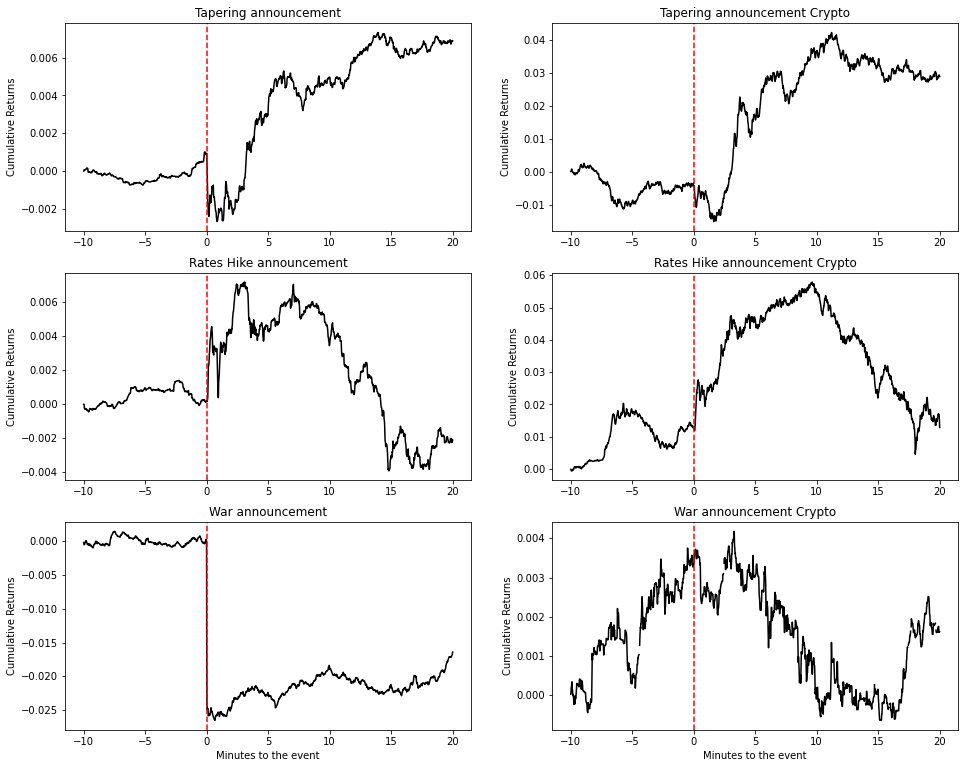

In [31]:
fig, axs = plt.subplots(3, 2, figsize=(16, 13)) # , sharex=True)
axs[0, 0].set_title('Tapering announcement')
axs[0, 0].plot(plot_tap.ret.cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[0, 0].axvline(x=0, linestyle='--', color= 'red')


axs[1, 0].set_title('Rates Hike announcement')  
axs[1, 0].plot(plot_rate.ret.cumsum(), color= 'black')
# plt.plot(data_SP500.loc[1643226600:1643228300].ret.cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[1, 0].axvline(x=0, linestyle='--', color= 'red') # 1643227200


axs[2, 0].set_title('War announcement')
axs[2, 0].plot(plot_war.ret.cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[2, 0].axvline(x=0, linestyle='--', color= 'red')
axs[2, 0].set(xlabel='Minutes to the event', ylabel='Cumulative Returns')



# tapering news impact CC:
axs[0, 1].set_title('Tapering announcement Crypto') 
axs[0, 1].plot(plot_tap_cc.ret.cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[0, 1].axvline(x=0, linestyle='--', color= 'red')


# rates hike CC
axs[1, 1].set_title('Rates Hike announcement Crypto')
axs[1, 1].plot(plot_rate_cc.ret.cumsum(), color= 'black')     
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[1, 1].axvline(x=0, linestyle='--', color= 'red')


# War news impact CC:
axs[2, 1].set_title('War announcement Crypto') 
axs[2, 1].plot(plot_war_cc.ret.cumsum(), color= 'black')      # 1645671600
axs[2, 1].axvline(x=0, linestyle='--', color= 'red')   # 1645670900 at 2.48 (18/20 mins after the news) 
axs[2, 1].set(xlabel='Minutes to the event', ylabel='Cumulative Returns')


for ax in axs.flat:
    ax.set( ylabel='Cumulative Returns') # xlabel='Minutes to the event',
    
    
plt.savefig("cum_ret_all.jpg")
# for ax in axs.flat:
#     ax.label_outer()

## Plot of cumulative returns over 4 hours and so it is easier to see the if there is a late effect (because in the short term there seem not to be any abnormal movement/change)

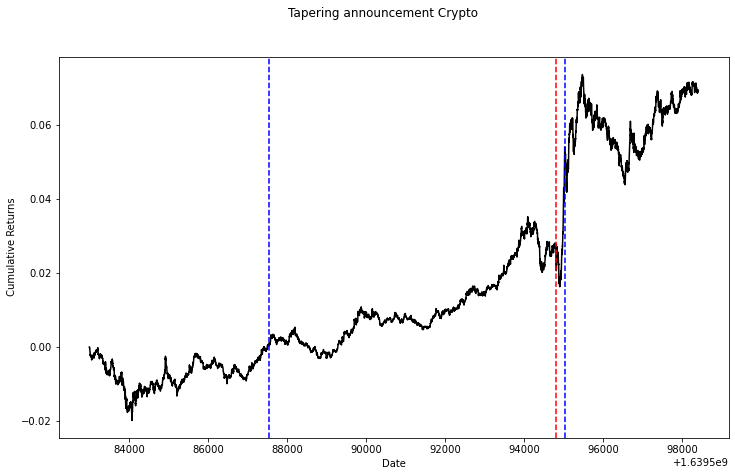

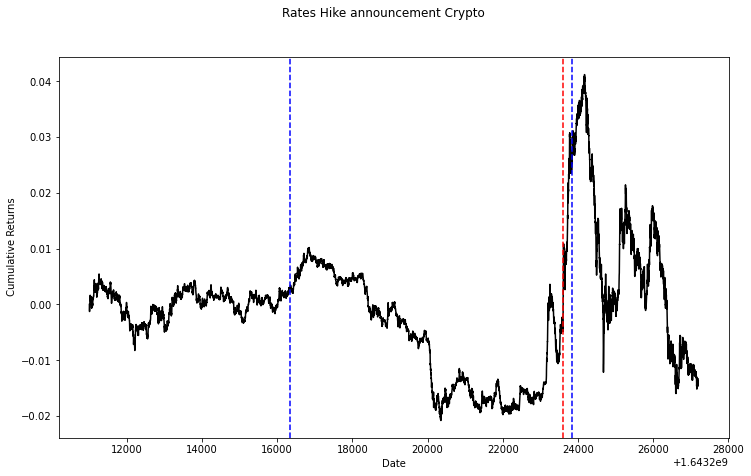

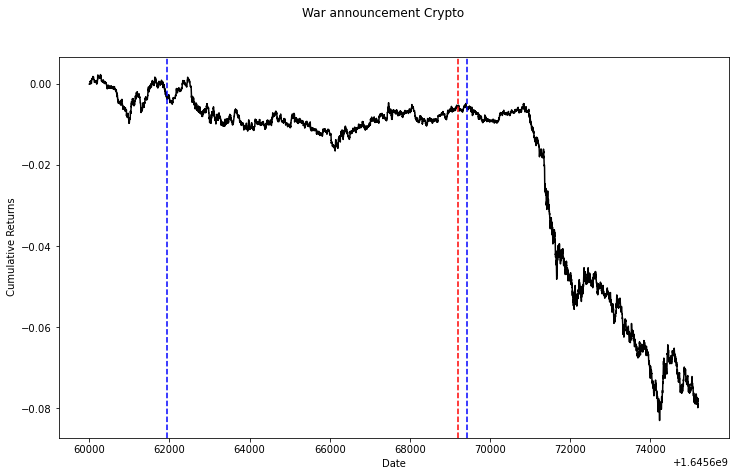

In [32]:
# should use the cumulative returns? in order to have bigger values and be able to evaluate them better(?)
# # rate hike news impact:     '''NB: the rates will be raised in some month, not imediately'''

# tapering news impact:
fig = plt.figure(figsize = (12,7))
fig.suptitle('Tapering announcement Crypto') 
plt.plot(tapering_1.ret.cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
plt.axvline(x=1639594800, linestyle='--', color= 'red')
plt.axvline(x=1639587540, linestyle='--', color= 'blue')
plt.axvline(x=1639595040, linestyle='--', color= 'blue')
plt.xlabel('Date')
plt.ylabel(' Cumulative Returns')
plt.savefig("plot_tapering_Crypto_extended.jpg")



fig = plt.figure(figsize = (12,7))
fig.suptitle('Rates Hike announcement Crypto')
plt.plot(rates_hike_1.ret.cumsum(), color= 'black')     
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
plt.axvline(x=1643223600, linestyle='--', color= 'red')
plt.axvline(x=1643216339, linestyle='--', color= 'blue')
plt.axvline(x=1643223840, linestyle='--', color= 'blue')
plt.xlabel('Date')
plt.ylabel(' Cumulative Returns')
plt.savefig("plot_rates_hike_Crypto_extended.jpg")

# War news impact:
# starting at 1645578000000 (1 GMT and 3 Amsterdam time)
# news from forbes arrived at 4.21 amsterdam time, so 2.21 GMT     1645582800000
# finishing at 1645588800000 (1 GMT and 6 Amsterdam time)
fig = plt.figure(figsize = (12,7))
fig.suptitle('War announcement Crypto') 
plt.plot(war_1.ret.cumsum(), color= 'black') 
plt.axvline(x=1645669200, linestyle='--', color= 'red')   # 1645670900 at 2.48 (18/20 mins after the news) 
# there is a movement in prices. 
plt.axvline(x=1645661940, linestyle='--', color= 'blue')    
plt.axvline(x=1645669440, linestyle='--', color= 'blue')
plt.xlabel('Date')
plt.ylabel(' Cumulative Returns')
plt.savefig("plot_war_Crypto_extended.jpg")



# <span style="color:red">Specific Crypto analysis</span> 

## I will use BTC, ETH, ADA and XRP (that were also in the CRIX and has different projects and blockchain structure) + DOGE that is "meme coin"


In [50]:
# function to create DF and modify the column names
def data_crypto(crypto, event_time, cat):
    # creating empty df that will be filled with the prices of the cryto
    df_crypto = pd.DataFrame()
    # getting the data from 3 hours before the event to 2 hours after
    start_time = event_time - 10800000
    for n in range (0,5):
        end_time = start_time+3600000
        response = requests.get('https://api.binance.com/api/v3/aggTrades?symbol=%(crypto)s&startTime=%(start_time)s&endTime=%(end_time)s' %locals())
        df = response.json()
        df = pd.DataFrame(df)
        df = df.drop(columns=['a', 'm', 'M', 'f', 'l', 'q'])
        df = df.rename(columns={'T': 'Timestamp', 'p':'price'}) #, 'q':'quantity'
        
        # changing from timestamp to seconds to the event
        df.Timestamp = round((df.Timestamp-event_time), -3)/1000
        df.price = df.price.astype(float)
        df = df.groupby(by=['Timestamp']).mean()
        # Adding the new dara to the previous df (of the same crypto)
        df_crypto = df_crypto.append(df)
        # continuing the rolling period of 1 hour
        start_time = start_time +3600000 
        
    # aftert making the df with the prices of the crypto over the period, I compute the log returns
    df_crypto['ret'] = np.log(df_crypto.price/df_crypto.price.shift())
    
    # then I compute the AR, CAR and I make the event study analysis as before, saving the excel file directly
    
    avg_ret = df_crypto.loc[-7260:-60].ret.mean()
    ar = pd.DataFrame(columns=['Seconds to the event', 'AAR', 'CAR', 'CAAR'], index = range(0,30))  # index = df.Date.iloc[600:]
    n = -60
    ar['significance'] = ''
    ar['significance_CAR'] = ''
    ar['significance_AR'] = ''
    df_crypto['AR'] = df_crypto.ret - avg_ret

    
    # trying to compute the CAR in a meaningful way 
    df_crypto['CAR'] = 0
    df_crypto.CAR.loc[-60:240] = df_crypto.loc[-60:240, 'AR'].cumsum()
    
    df_crypto = df_crypto.fillna(0)
    AAR = df_crypto.loc[-7260:-60, 'AR'].mean() 
    

    # considering the return every 10 seconds (or better to use the average return over the 10 seconds?)
    for i in range(0, 30):
        ar['Seconds to the event'].iloc[i] = n
        
    # AR is: observed ret-average
    # I compute the Cumulative Abnormal Return for every 10 seconds
        ar.CAR.iloc[i] = df_crypto.CAR.loc[n:n+10].mean()
 
    # I compute the Average Abnormal Return for every 10 seconds
        ar.AAR.iloc[i] = df_crypto.AR.loc[n:n+10].mean()
        
        n = n +10
    # I compute the Cumulative Average Abnormal Return for every 10 seconds, summing the AAR    
    ar.CAAR = ar.AAR.cumsum()
    
    # computing also the significance value of every AR and CAR for every second with the simple t-test
    df_crypto['t_test_AR'] = 0.0001
    df_crypto['t_test_AR'].loc[-60:] = (df_crypto.AR.loc[-60:]/np.std(df_crypto.AR.loc[-7260:-60])) 
    
    # column to add the significance of the AR to the df
    df_crypto['signif'] = 0.0
    
######################## fix error with the following ################################################
    
    df_crypto.signif.loc[df_crypto['t_test_AR'] >= 1.65] = '*'
    df_crypto.signif.loc[df_crypto['t_test_AR'] <= -1.65] = '*'
    df_crypto.signif.loc[df_crypto['t_test_AR'] >= 1.96] = '**'
    df_crypto.signif.loc[df_crypto['t_test_AR'] <= -1.96] = '**'
    df_crypto.signif.loc[df_crypto['t_test_AR'] >= 2.58] = '***'
    df_crypto.signif.loc[df_crypto['t_test_AR'] <= -2.58] = '***'


    
    # formula to compute the p-value using the shapiro test for normality:
    shapiro_test_norm = shapiro(ar.CAR).pvalue
    print('Shapiro Test for normality: ' + str(shapiro_test_norm))
    
    if shapiro_test_norm > 0.05:  # normally distributed CAR 
        ar['t_test_CAR'] = ar.CAR/np.std(ar.CAR)
        ar['t_test_AR'] = ar.AAR/np.std(ar.AAR)
        
        ar.significance_CAR.loc[ar['t_test_CAR'] >= 1.65] = '*'
        ar.significance_CAR.loc[ar['t_test_CAR'] <= -1.65] = '*'
        ar.significance_CAR.loc[ar['t_test_CAR'] >= 1.96] = '**'
        ar.significance_CAR.loc[ar['t_test_CAR'] <= -1.96] = '**'
        ar.significance_CAR.loc[ar['t_test_CAR'] >= 2.58] = '***'
        ar.significance_CAR.loc[ar['t_test_CAR'] <= -2.58] = '***'
        
        ar.significance_AR.loc[ar['t_test_AR'] >= 1.65] = '*'
        ar.significance_AR.loc[ar['t_test_AR'] <= -1.65] = '*'
        ar.significance_AR.loc[ar['t_test_AR'] >= 1.96] = '**'
        ar.significance_AR.loc[ar['t_test_AR'] <= -1.96] = '**'
        ar.significance_AR.loc[ar['t_test_AR'] >= 2.58] = '***'
        ar.significance_AR.loc[ar['t_test_AR'] <= -2.58] = '***'
        print('Normal distributed CAR')
        
        
    # sigma of AR in the estimation window
    sigma = sqrt(sum((df_crypto.AR.loc[-7260:-60]-AAR)**2)/7200)

    # computing t-statistics for AAR and CAAR
    ar['t_test_AAR'] = ar.AAR/sigma
    ar['t_test_CAAR'] = ar.CAAR/((301**0.5)*sigma)

    ar['significance_CAAR'] = ''
    ar.significance_CAAR.loc[ar['t_test_CAAR'] >= 1.65] = '*'
    ar.significance_CAAR.loc[ar['t_test_CAAR'] <= -1.65] = '*'
    ar.significance_CAAR.loc[ar['t_test_CAAR'] >= 1.96] = '**'
    ar.significance_CAAR.loc[ar['t_test_CAAR'] <= -1.96] = '**'
    ar.significance_CAAR.loc[ar['t_test_CAAR'] >= 2.58] = '***'
    ar.significance_CAAR.loc[ar['t_test_CAAR'] <= -2.58] = '***'
    
    
    ar.significance.loc[ar['t_test_AAR'] >= 1.65] = '*'
    ar.significance.loc[ar['t_test_AAR'] <= -1.65] = '*'
    ar.significance.loc[ar['t_test_AAR'] >= 1.96] = '**'
    ar.significance.loc[ar['t_test_AAR'] <= -1.96] = '**'
    ar.significance.loc[ar['t_test_AAR'] >= 2.58] = '***'
    ar.significance.loc[ar['t_test_AAR'] <= -2.58] = '***'
    # setting the degrees of freedom: in the reference paper are 120 (days of the estimation window - 1)
    # so here are 7200 - 1 = 7199
    dof = 7199
    for i in range(0, len(ar.t_test_AAR)):
        ar.t_test_AAR.iloc[i] = 2*(1 - t.cdf(abs(ar.t_test_AAR.iloc[i]), dof))
#############         ar.t_test_CAAR.iloc[i] = 2*(1 - t.cdf(abs(ar.t_test_CAAR.iloc[i]), dof))
    
    ar = ar.set_index('Seconds to the event')


    

        
    df_crypto['CAR'] = df_crypto['AR'].cumsum()    
        
        
        
#     ar.to_excel(locals()[str(crypto)+'.xlsx']) 
    ar.to_excel(str(crypto)+'_'+str(cat)+'.xlsx') 

    return df_crypto, ar
        

In [51]:
# getting the data and dividing into the categories. every result has in position 0 the FULL df with prices and AR, CAR (5 hours of data)
# and the t-test on AR. in the position 1 of each result there are the AAR and CAAR over the 5 mins of the event window
###### REGULATION:
BTC_reg = data_crypto('BTCUSDT', 1632474001000, 'reg')
ETH_reg = data_crypto('ETHUSDT', 1632474001000, 'reg')
XRP_reg = data_crypto('XRPUSDT', 1608664380000, 'reg')
DOGE_reg = data_crypto('DOGEUSDT', 1619635290000, 'reg')
ADA_reg = data_crypto('ADAUSDT', 1637703363000, 'reg')

###### PROJECTS and ADOPOTIONS
BTC_proj = data_crypto('BTCUSDT', 1623218754000, 'proj')
ETH_proj = data_crypto('ETHUSDT', 1653024783000, 'proj')
XRP_proj = data_crypto('XRPUSDT', 1647854160000, 'proj')
DOGE_proj = data_crypto('DOGEUSDT', 1639478063000, 'proj')
ADA_proj = data_crypto('ADAUSDT', 1653494700000, 'proj')

###### OPINION OF INFLUENT PEOPLE 
BTC_infl = data_crypto('BTCUSDT', 1622768824000, 'infl')      # around 4.5 mins it starts a significance movement 
ETH_infl = data_crypto('ETHUSDT', 1556586953000, 'infl')
XRP_infl = data_crypto('XRPUSDT', 1632684902000, 'infl')     # price was already dropping and after the event, some minutes later, the trend inverted 
DOGE_infl = data_crypto('DOGEUSDT', 1618461198000, 'infl')    # super fast impact on the price
ADA_infl = data_crypto('ADAUSDT', 1634325373000, 'infl')



/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Shapiro Test for normality: 0.003352167783305049


/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Shapiro Test for normality: 4.7998946683947e-05


/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Shapiro Test for normality: 0.12410986423492432
Normal distributed CAR


/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Shapiro Test for normality: 0.1885988861322403
Normal distributed CAR


/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Shapiro Test for normality: 0.0003481956082396209


/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Shapiro Test for normality: 0.01496801059693098


/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Shapiro Test for normality: 0.039579927921295166


/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Shapiro Test for normality: 0.0957849994301796
Normal distributed CAR


/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Shapiro Test for normality: 0.0029129197355359793


/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Shapiro Test for normality: 1.0
Normal distributed CAR


/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Shapiro Test for normality: 0.0018885325407609344


/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Shapiro Test for normality: 0.08910564333200455
Normal distributed CAR


/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Shapiro Test for normality: 0.1405482292175293
Normal distributed CAR


/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Shapiro Test for normality: 0.0035197294782847166
Shapiro Test for normality: 0.24575605988502502
Normal distributed CAR


/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/leo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Text(0, 0.5, ' Cumulative Returns')

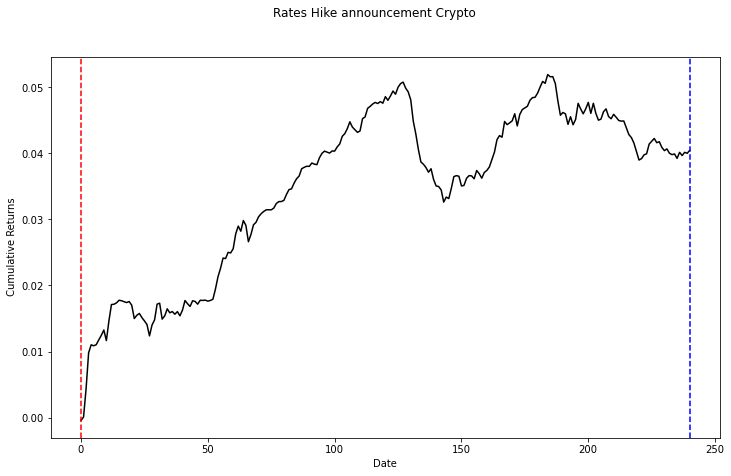

In [60]:
DOGE_infl[0].loc[0:50]
fig = plt.figure(figsize = (12,7))
fig.suptitle('Rates Hike announcement Crypto')
plt.plot(DOGE_infl[0].ret.loc[0:240].cumsum(), color= 'black')     
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
plt.axvline(x=0, linestyle='--', color= 'red')
plt.axvline(x=240, linestyle='--', color= 'blue')
# plt.axvline(x=-7260, linestyle='--', color= 'blue')
plt.xlabel('Date')
plt.ylabel(' Cumulative Returns')
# plt.savefig("plot_rates_hike_Crypto_extended.jpg")

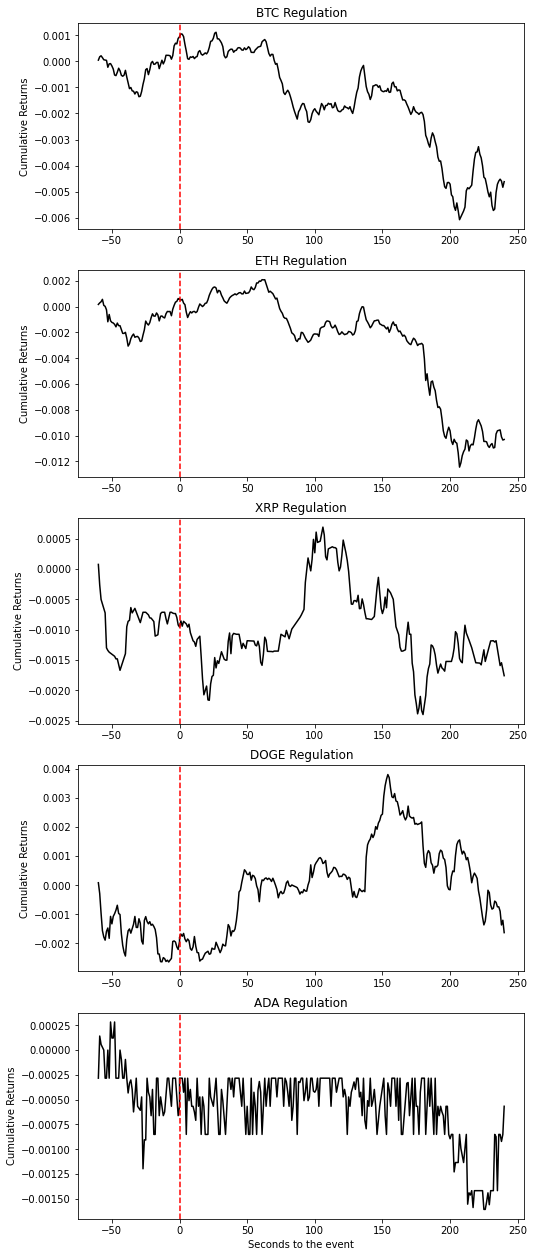

In [78]:
fig, axs = plt.subplots(5, 1, figsize=(8, 22)) # , sharex=True)
axs[0].set_title('BTC Regulation')
axs[0].plot(BTC_reg[0].ret.loc[-60:240].cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[0].axvline(x=0, linestyle='--', color= 'red')


axs[1].set_title('ETH Regulation')  
axs[1].plot(ETH_reg[0].ret.loc[-60:240].cumsum(), color= 'black')
# plt.plot(data_SP500.loc[1643226600:1643228300].ret.cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[1].axvline(x=0, linestyle='--', color= 'red') # 1643227200


axs[2].set_title('XRP Regulation')
axs[2].plot(XRP_reg[0].ret.loc[-60:240].cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[2].axvline(x=0, linestyle='--', color= 'red')


axs[3].set_title('DOGE Regulation')  
axs[3].plot(DOGE_reg[0].ret.loc[-60:240].cumsum(), color= 'black')
# plt.plot(data_SP500.loc[1643226600:1643228300].ret.cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[3].axvline(x=0, linestyle='--', color= 'red') # 1643227200


axs[4].set_title('ADA Regulation')
axs[4].plot(ADA_reg[0].ret.loc[-60:240].cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[4].axvline(x=0, linestyle='--', color= 'red')
axs[4].set(xlabel='Seconds to the event', ylabel='Cumulative Returns')




for ax in axs.flat:
    ax.set( ylabel='Cumulative Returns') 
    
    
plt.savefig("cum_ret_reg.jpg")


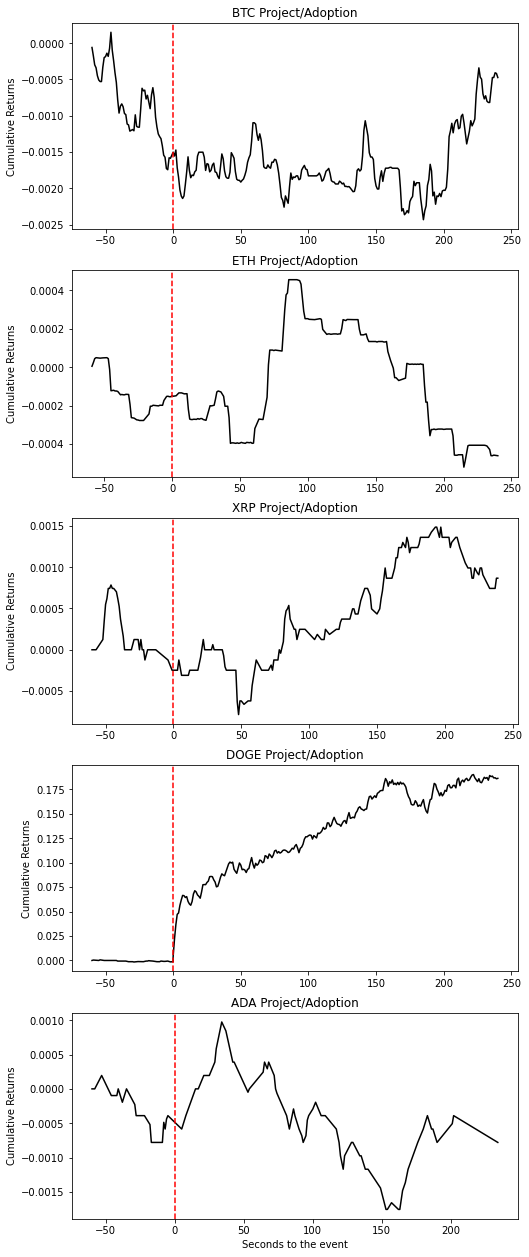

In [73]:
fig, axs = plt.subplots(5, 1, figsize=(8, 22)) # , sharex=True)
axs[0].set_title('BTC Project/Adoption')
axs[0].plot(BTC_proj[0].ret.loc[-60:240].cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[0].axvline(x=0, linestyle='--', color= 'red')


axs[1].set_title('ETH Project/Adoption')  
axs[1].plot(ETH_proj[0].ret.loc[-60:240].cumsum(), color= 'black')
# plt.plot(data_SP500.loc[1643226600:1643228300].ret.cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[1].axvline(x=0, linestyle='--', color= 'red') # 1643227200


axs[2].set_title('XRP Project/Adoption')
axs[2].plot(XRP_proj[0].ret.loc[-60:240].cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[2].axvline(x=0, linestyle='--', color= 'red')


axs[3].set_title('DOGE Project/Adoption')  
axs[3].plot(DOGE_proj[0].ret.loc[-60:240].cumsum(), color= 'black')
# plt.plot(data_SP500.loc[1643226600:1643228300].ret.cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[3].axvline(x=0, linestyle='--', color= 'red') # 1643227200


axs[4].set_title('ADA Project/Adoption')
axs[4].plot(ADA_proj[0].ret.loc[-60:240].cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[4].axvline(x=0, linestyle='--', color= 'red')
axs[4].set(xlabel='Seconds to the event', ylabel='Cumulative Returns')




for ax in axs.flat:
    ax.set( ylabel='Cumulative Returns') 
    
    
plt.savefig("cum_ret_proj.jpg")


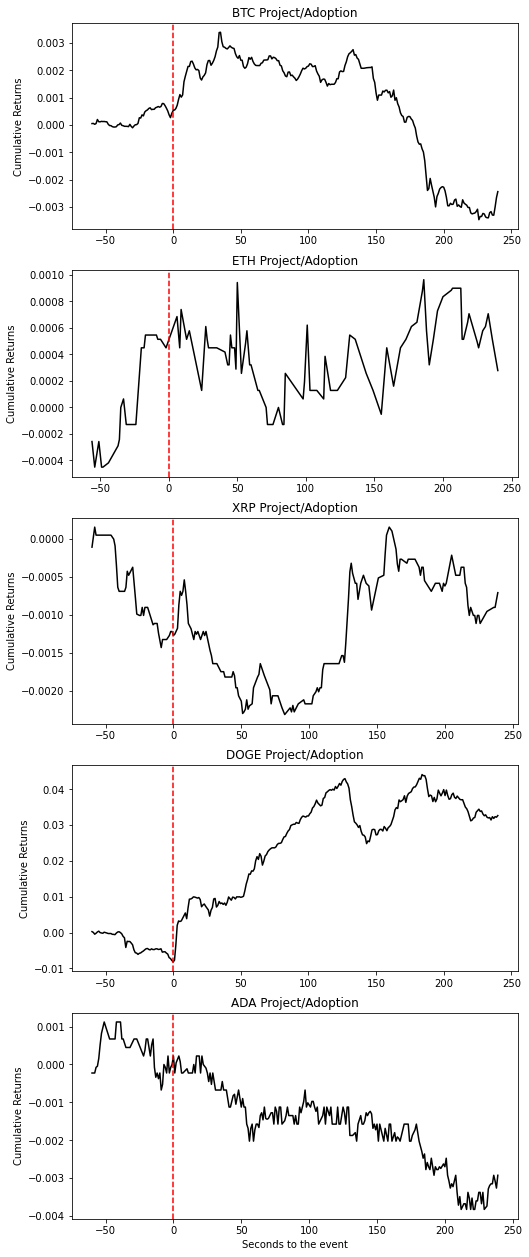

In [85]:
fig, axs = plt.subplots(5, 1, figsize=(8, 22)) # , sharex=True)
axs[0].set_title('BTC Project/Adoption')
axs[0].plot(BTC_infl[0].ret.loc[-60:240].cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[0].axvline(x=0, linestyle='--', color= 'red')


axs[1].set_title('ETH Project/Adoption')  
axs[1].plot(ETH_infl[0].ret.loc[-60:240].cumsum(), color= 'black')
# plt.plot(data_SP500.loc[1643226600:1643228300].ret.cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[1].axvline(x=0, linestyle='--', color= 'red') # 1643227200


axs[2].set_title('XRP Project/Adoption')
axs[2].plot(XRP_infl[0].ret.loc[-60:240].cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[2].axvline(x=0, linestyle='--', color= 'red')


axs[3].set_title('DOGE Project/Adoption')  
axs[3].plot(DOGE_infl[0].ret.loc[-60:240].cumsum(), color= 'black')
# plt.plot(data_SP500.loc[1643226600:1643228300].ret.cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[3].axvline(x=0, linestyle='--', color= 'red') # 1643227200


axs[4].set_title('ADA Project/Adoption')
axs[4].plot(ADA_infl[0].ret.loc[-60:240].cumsum(), color= 'black')
# plt.xticks(data_SP500.loc[1639597800:1639598700].index, data_SP500.loc[1639597800:1639598700].Date, rotation=90)
axs[4].axvline(x=0, linestyle='--', color= 'red')
axs[4].set(xlabel='Seconds to the event', ylabel='Cumulative Returns')




for ax in axs.flat:
    ax.set( ylabel='Cumulative Returns') 
    
    
plt.savefig("cum_ret_infl.jpg")


In [146]:
# results for the table of the comparison between the 3 categories
regulation_average_AR = (BTC_reg[0].loc[4, 'AR'] + ETH_reg[0].loc[5, 'AR'] + DOGE_reg[0].loc[44, 'AR'] + ADA_reg[0].loc[5, 'AR'])/4
regulation_average_CAR = (BTC_reg[0].loc[0:60, 'AR'].cumsum().mean()+ETH_reg[0].loc[0:60, 'AR'].cumsum().mean()+XRP_reg[0].loc[0:60, 'AR'].cumsum().mean()+DOGE_reg[0].loc[0:60, 'AR'].cumsum().mean()+ADA_reg[0].loc[0:60, 'AR'].cumsum().mean())/5
regulation_average_CAR_10 = (BTC_reg[0].loc[0:600, 'AR'].cumsum().mean()+ETH_reg[0].loc[0:600, 'AR'].cumsum().mean()+XRP_reg[0].loc[0:600, 'AR'].cumsum().mean()+DOGE_reg[0].loc[0:600, 'AR'].cumsum().mean()+ADA_reg[0].loc[0:600, 'AR'].cumsum().mean())/5


#dropping the first rows of BTC and DOGE because without values 
BTC_proj_clean = (BTC_proj[0].loc[0:60]).iloc[1:,:]
DOGE_proj_clean = (DOGE_proj[0].loc[0:60]).iloc[1:,:]

proj_average_AR = (XRP_proj[0].loc[22, 'AR']+ DOGE_proj_clean.loc[0, 'AR'] + ADA_proj[0].loc[42, 'AR'])/3
proj_average_CAR = (BTC_proj_clean.loc[0:60, 'AR'].cumsum().mean()+ETH_proj[0].loc[0:60, 'AR'].cumsum().mean()+XRP_proj[0].loc[0:60, 'AR'].cumsum().mean()+DOGE_proj_clean.loc[0:60, 'AR'].cumsum().mean()+ADA_proj[0].loc[0:60, 'AR'].cumsum().mean())/5
proj_average_CAR_10 = (BTC_proj[0].loc[0:600, 'AR'].cumsum().mean()+ETH_proj[0].loc[0:600, 'AR'].cumsum().mean()+XRP_proj[0].loc[0:600, 'AR'].cumsum().mean()+DOGE_proj_clean.loc[0:60, 'AR'].cumsum().mean()+ADA_proj[0].loc[0:600, 'AR'].cumsum().mean())/5

#dropping the first rows of BTC and DOGE because without values 
BTC_infl_clean = (BTC_infl[0].loc[0:60]).iloc[1:,:]
DOGE_infl_clean = (DOGE_infl[0].loc[0:60]).iloc[1:,:]

infl_average_AR = (BTC_infl_clean.loc[8, 'AR'] + ETH_infl[0].loc[24, 'AR'] + DOGE_infl_clean.loc[2, 'AR'] + XRP_infl[0].loc[4, 'AR'])/4
infl_average_CAR = (BTC_infl_clean.loc[0:60, 'AR'].cumsum().mean()+ETH_infl[0].loc[0:60, 'AR'].cumsum().mean()+XRP_infl[0].loc[0:60, 'AR'].cumsum().mean()+DOGE_infl_clean.loc[0:60, 'AR'].cumsum().mean()+ADA_infl[0].loc[0:60, 'AR'].cumsum().mean())/5
infl_average_CAR_10 = (BTC_infl[0].loc[0:600, 'AR'].cumsum().mean()+ETH_infl[0].loc[0:600, 'AR'].cumsum().mean()+XRP_infl[0].loc[0:600, 'AR'].cumsum().mean()+DOGE_infl[0].loc[0:600, 'AR'].cumsum().mean()+ADA_infl[0].loc[0:600, 'AR'].cumsum().mean())/5


print(regulation_average_AR, regulation_average_CAR, regulation_average_CAR_10) 


-0.0002140183606973183 4.598574176769546e-05 -0.003957663775248988
